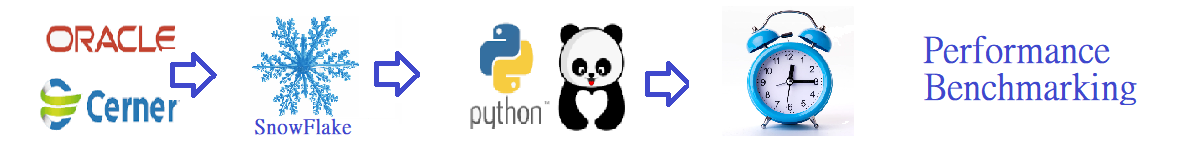

### This solution produces a performance benchmark for any workflow or SQL you want to utilize.

## Required Setup Step 0 - Import all necessary Libraries


In [1]:
# Import Libraries for Spreadsheet Automation 
import pandas as pd
import datetime as dt
from datetime import date
import os, glob, time
import rpa_excel as re
import file_manager as fm 
import snowflake.connector
from platform import python_version

## Optional Step 0 - initiate the configuration parser and name the solution

In [2]:
# Configure the code and visual settings to have consistency 
import configparser
config = configparser.ConfigParser()
config.read('config.ini') 

solution_name = 'sql_benchmark'
current_working_directory = os.getcwd()

## Optional Step 0 - initiate the logger 

In [3]:
import logging # built in python library that does not need to be installed 
import quick_logger as ql  # Establish the Python Logger  

global start_stime 
start_time = ql.set_start_time()
logging = ql.create_logger_Start(solution_name, start_time) 

## Step 1 - Establish a function for any SNOWFLAKE fetch 

In [4]:
def get_dataframe_from_SQL(SQL): 
    # Change the follwoing to YOUR credentials 
    ctx = snowflake.connector.connect(
        user='JOE EBERLE',
        password='Jae$2052sf',
        account='cerner-healtheedw_wny')

    cur = ctx.cursor()  # Create a cursor object.
    cur.execute(SQL) # Esecute the passed in SQL 

    # Fetch the result set from the cursor and deliver it as the Pandas DataFrame.
    df = cur.fetch_pandas_all()
    cur.close()
    ctx.close()
    return df 


debugging_and_testing = False 
if debugging_and_testing:
    sql = "select sysdate() as Process_Date, * from WNY_DB.WNY.PH_D_PERSONNEL_GROUP "
    df_PH_D_PERSONNEL_GROUP = get_dataframe_from_SQL(sql)
    df_PH_D_PERSONNEL_GROUP.head(2) 
    log_print(f'Step 1- {df_PH_D_PERSONNEL_GROUP.shape[0]} personell groups with {df_PH_D_PERSONNEL_GROUP.shape[1]} data columns')

In [5]:
sql_start_time = time.time()

gsql = "select distinct ea.*"
gsql = gsql + ", ce.event_title_text "
gsql = gsql + ", ce.event_tag "
gsql = gsql + ", ce.result_val "
gsql = gsql + ", ce.updt_applctx "
gsql = gsql + ", ce.performed_dt_tm "
gsql = gsql + ", ce.updt_dt_tm "
gsql = gsql + ", ce.last_utc_ts "
gsql = gsql + "from (select distinct encntr_id, alias as FIN from  WNY_DB.wny_prod.encntr_alias where encntr_alias_type_cd = '844' and alias = '73154281') ea "
gsql = gsql + "inner join (select * from  WNY_DB.wny_prod.clinical_event "
gsql = gsql + "where (event_tag = 'Clinic' and event_title_text = 'BAR Lost to FollowUp') "
gsql = gsql + "or event_title_text in ('Lost to Followup Complete', 'Phone Call Attempt One Date', 'Letter One Mailed Date', 'Followup Time Frame') "
gsql = gsql + ") ce on ea.encntr_id = ce.encntr_id "
df_gsql = get_dataframe_from_SQL(gsql)

sql_stop_time = time.time()

sql_process_duration = sql_stop_time - sql_start_time

ql.pvlog('info',f'Step 1  sql benchmark  {df_gsql.shape[0]} rows and {df_gsql.shape[1]} data columns')  

df_gsql.head(20)

if sql_process_duration > 600.0:
    ql.pvlog('info',f'LONG process duration greater than 10 Minutes:{sql_process_duration:.2f}') 
elif sql_process_duration > 120.0:
    ql.pvlog('info',f'Medium process duration greater than 2 minutes:{sql_process_duration:.2f}') 
elif sql_process_duration > 3.0:
    ql.pvlog('info',f'Low process duration less than 2 minutes:{sql_process_duration:.2f}') 
elif sql_process_duration < 3.0:
    ql.pvlog('info',f'Short process duration less than 3 Seconds:{sql_process_duration:.2f}') 
else:  
    ql.pvlog('info',f'Unknown Duration')    
    
df_gsql.head(20)    


Step 1  sql benchmark  12 rows and 9 data columns
Short process duration less than 3 Seconds:1.21


,ENCNTR_ID,FIN,EVENT_TITLE_TEXT,EVENT_TAG,RESULT_VAL,UPDT_APPLCTX,PERFORMED_DT_TM,UPDT_DT_TM,LAST_UTC_TS
0,81932010,73154281,Letter One Mailed Date,Letter One Mailed Date,1:2019032600000000:0.000000:0:0,1756342708,2020-01-29 13:24:00-05:00,2020-01-29 13:24:25-05:00,2020-01-29 13:24:25.450000-05:00
1,81932010,73154281,Phone Call Attempt One Date,Phone Call Attempt One Date,1:2019032600000000:0.000000:0:0,1756342708,2020-01-29 13:24:00-05:00,2020-01-29 13:24:25-05:00,2020-01-29 13:24:25.445000-05:00
2,81932010,73154281,Phone Call Attempt One Date,Phone Call Attempt One Date,1:2019032600000000:0.000000:0:0,1149580630,2019-03-26 10:19:37-04:00,2019-03-26 10:21:06-04:00,2019-03-26 10:21:06.628000-04:00
3,81932010,73154281,BAR Lost to FollowUp,Clinic,None,1756342708,2020-01-29 13:24:00-05:00,2020-01-29 13:24:26-05:00,2020-01-29 13:24:25.767000-05:00
4,81932010,73154281,BAR Lost to FollowUp,Clinic,None,1149580630,2019-03-26 10:19:37-04:00,2019-03-26 10:21:07-04:00,2019-03-26 10:21:06.983000-04:00
5,81932010,73154281,Followup Time Frame,Followup Time Frame,3 years,1149580630,2019-03-26 10:19:37-04:00,2019-03-26 10:21:06-04:00,2019-03-26 10:21:06.628000-04:00
6,81932010,73154281,Followup Time Frame,Followup Time Frame,3 years,1756342708,2020-01-29 13:24:00-05:00,2020-01-29 13:24:25-05:00,2020-01-29 13:24:25.432000-05:00
7,81932010,73154281,Letter One Mailed Date,Letter One Mailed Date,1:2019032600000000:0.000000:0:0,1149580630,2019-03-26 10:19:37-04:00,2019-03-26 10:21:06-04:00,2019-03-26 10:21:06.628000-04:00
8,81932010,73154281,Followup Time Frame,Followup Time Frame,4 years,1756342708,2020-01-29 13:24:00-05:00,2020-01-29 13:24:25-05:00,2020-01-29 13:24:25.452000-05:00
9,81932010,73154281,Letter One Mailed Date,Letter One Mailed Date,1:2020012900000000:0.000000:0:0,1756342708,2020-01-29 13:24:00-05:00,2020-01-29 13:24:25-05:00,2020-01-29 13:24:25.452000-05:00


## Step 0 - Optional Steps below to document and store Log files

In [6]:
# Calculate and classify the process performance 
status = ql.calculate_process_performance(solution_name, start_time) 
print(ql.append_log_file(solution_name))  

2023-06-15 14:47:12,010 - INFO - START sql_benchmark =============================================
2023-06-15 14:47:12,011 - INFO - START sql_benchmark Start Time = 2023-06-15 14:47:12
2023-06-15 14:47:12,011 - INFO - sql_benchmark Step 0 - Initialize the configuration file parser
2023-06-15 14:47:12,047 - INFO - Snowflake Connector for Python Version: 2.7.11, Python Version: 3.8.13, Platform: Windows-10-10.0.19044-SP0
2023-06-15 14:47:12,048 - INFO - This connection is in OCSP Fail Open Mode. TLS Certificates would be checked for validity and revocation status. Any other Certificate Revocation related exceptions or OCSP Responder failures would be disregarded in favor of connectivity.
2023-06-15 14:47:12,048 - INFO - Setting use_openssl_only mode to False
2023-06-15 14:47:12,860 - INFO - query: [select distinct ea.*, ce.event_title_text , ce.event_tag , ce.result_val , ce.up...]
2023-06-15 14:47:12,977 - INFO - query execution done
2023-06-15 14:47:13,134 - INFO - closed
2023-06-15 14